# Text Classification with RNNs
(Core)

*Christina Brockway*

Using the following dataset:
https://drive.google.com/file/d/1uUtuiAM1AqGvDMrd3-L8vLFfHPrt3pWG/view?usp=sharing

This is the "spooky" dataset and repfresents passages from 3 famous authors:  Edgar Allen Poe, HP Lovecreaft, Mary Shelley.

#### Start with Vectorization Layer Practice Notebook

In [1]:
## Imports

import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

%load_ext autoreload
%autoreload 2
import my_functions as mf


In [2]:
df=pd.read_csv("data/spooky.csv", index_col='id')
#Length of each test
df['length'] = df['text'].map(lambda x:  len(x.split(" ")))
df['author'].value_counts(normalize=True)
#Use random undersampler
sampler= RandomUnderSampler(random_state=42)
df, _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [3]:
## Create a map for targets
target_map = {'EAP':0, 'HPL':1, 'MWS':2}
y=df['author'].map(target_map)
y.value_counts(normalize=True)

0    0.333333
1    0.333333
2    0.333333
Name: author, dtype: float64

In [4]:
# Set classes variable
classes = y.unique()

# Define X 
X=df['text'].values

#Convert dataset to object
ds = tf.data.Dataset.from_tensor_slices((X, y))

#Shuffle dataset
ds= ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)
#Train/Val/Test Split

# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)

# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)

# Test size is remainder
split_test = 1 - (split_train + split_val)
n_test_samples = len(ds)-(n_train_samples+n_val_samples)

BATCH_SIZE=20

import math
train_batch = math.ceil(n_train_samples/BATCH_SIZE)
val_batch = math.ceil(n_val_samples/BATCH_SIZE)
test_batch = math.ceil(n_test_samples/BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {n_train_samples} samples as training data, {train_batch} training batches.')
print (f' TThere are {n_val_samples} samples as validation data, {val_batch} training batches.')
print (f' There are {n_test_samples} samples as testing data, {test_batch} training batches.')

 There are 11833 samples as training data, 592 training batches.
 TThere are 3381 samples as validation data, 170 training batches.
 There are 1691 samples as testing data, 85 training batches.


In [5]:
# use the "take" and "skip" methods to make the splits.

# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
val_ds = val_ds.take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

SEQ_LENGTH = 100
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation', output_mode='int',
    output_sequence_length=SEQ_LENGTH)

# Define output dimension
EMBED_DIM = 100


#Obtain the text from the training dataset using a lambda function
ds_text = train_ds.map(lambda x,y:x)

## Train (adapt) the vectorization layer on the text data
sequence_vectorizer.adapt(ds_text)
sequence_vectorizer.vocabulary_size()

# set the size of the vocabulary
VOCAB_SIZE = len(sequence_vectorizer.get_vocabulary())

# Get list of vocabulary words
vocabulary = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocabulary)}

### Improve RNN model
Build, fit, and evaluate at least 3 models using architecture or techniques you have learned in the course. Consider stacked RNNs, bi-directional RNNs, pre-trained word embeddings, pooling layers, dropout layers, and tuning of hyperparameters. Your goal should be to achieve the highest accuracy possible. An accuracy score above 80% is achievable.



### Model 1
#### Start with a RNN model with:

- 4 GRU layers, units = 128
- Dropout layers decreasing from 0.5 to 0.1 following each GRU layer
- Early Stopping
- max pooling layer
- dense layer

In [6]:
def build_gru_model_stack_hierarchy_pool(sequence_vectorizer):
    
    
    MAX_TOKENS = sequence_vectorizer.vocabulary_size()
        
    model = tf.keras.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQ_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.3))         
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.1)) 
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



In [7]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


In [8]:
# Build model
model1= build_gru_model_stack_hierarchy_pool(sequence_vectorizer)

EPOCHS = 30
history = model1.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 100)          2097600   
                                                                 
 gru (GRU)                   (None, 100, 128)          88320     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 100, 128)          99072     
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                        

In [9]:
# save model
#fpath_model = "models/Model1_stacked_GRU.keras"
#tf.keras.models.save_model(model1, fpath_model, save_format=tf)

In [59]:
# load model from jsoon file
#model1= tf.keras.models.load_model(fpath_model)

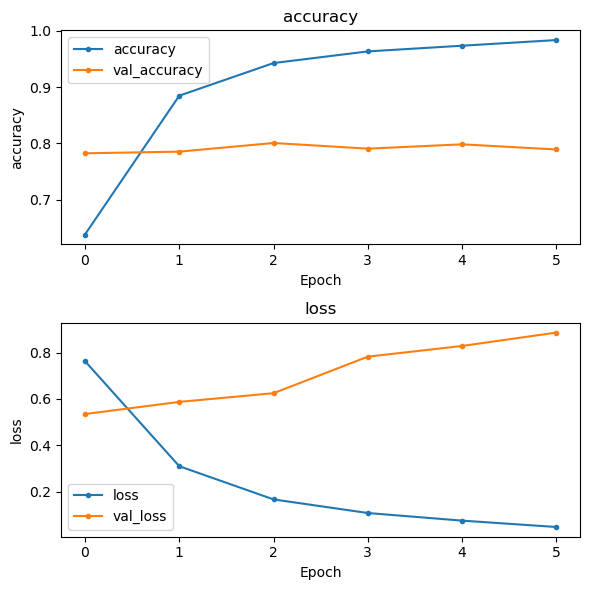


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       559
           1       0.89      0.72      0.80       560
           2       0.79      0.84      0.81       572

    accuracy                           0.80      1691
   macro avg       0.81      0.80      0.80      1691
weighted avg       0.81      0.80      0.80      1691



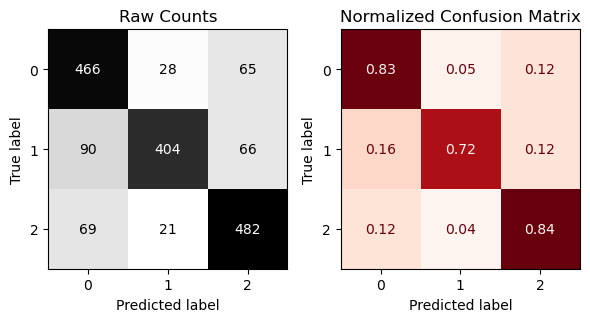


- Evaluating Test Data:
85/85 [==============================] - 4s 46ms/step - loss: 0.8932 - accuracy: 0.7995
{'loss': 0.8932428359985352, 'accuracy': 0.7995269298553467}


In [12]:
results = mf.evaluate_classification_network(
    model1,
    X_test=test_ds, history=history)

### Model 2
#### Improve RNN mode 1 with:
-  4 GRU layers, units **= 128, 64,32**
-  **LSTM layer following 1st dropout layer units=128**
-  
Dropout layers decreasing from 0.5 to 0.1 following each GRU ayera
- 
Early St  g, and only **20 EPOCHS**
-  xxmac poolil-  a
-  er
ensre rlaye

In [13]:
def build_hybrid_stacked_pool(sequence_vectorizer):
    
    
    MAX_TOKENS = sequence_vectorizer.vocabulary_size()
        
    model = tf.keras.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQ_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(.3))         
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.Dropout(.1)) 
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(32, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [14]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [15]:
# Build model
model2= build_hybrid_stacked_pool(sequence_vectorizer)

EPOCHS = 20
history2 = model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 100, 100)          2097600   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          88320     
                                                                 
 dropout_3 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                      

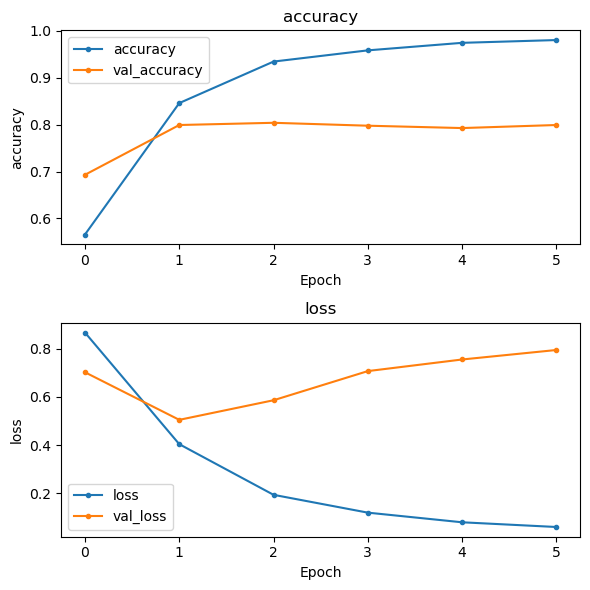


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       559
           1       0.81      0.82      0.82       560
           2       0.82      0.83      0.82       572

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



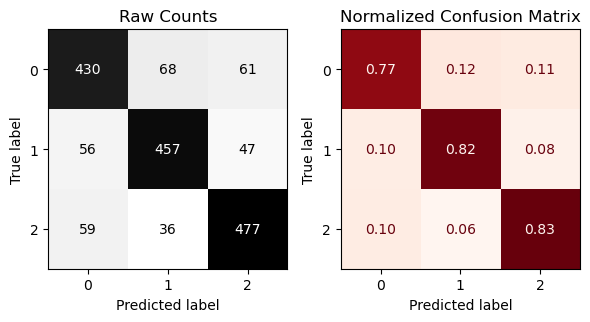


- Evaluating Test Data:
85/85 [==============================] - 4s 52ms/step - loss: 0.7817 - accuracy: 0.8066
{'loss': 0.7816510200500488, 'accuracy': 0.8066232800483704}


In [16]:
results2 = mf.evaluate_classification_network(
    model2,
    X_test=test_ds, history=history2)

### Model 3

#### Improve RNN model 2 with:
-  4 GRU layers, units = 128, 64, 32
-  LSTM layer following 1st dropout layer units=128
-  Dropout layers decreasing from 0.5 to 0.1 following each GRU layer
-  Early Stoping
-  max pooling layer
-  dense layer, **activation='sigmoid'**

In [17]:
def build_GRU_LSTM_stacked_pool(sequence_vectorizer):
    
    
    MAX_TOKENS = sequence_vectorizer.vocabulary_size()
        
    model = tf.keras.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQ_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(.3))         
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.Dropout(.1)) 
   
    model.add(layers.GRU(32, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='sigmoid'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [18]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [19]:
# Build model
model3= build_GRU_LSTM_stacked_pool(sequence_vectorizer)

EPOCHS = 20
history3 = model3.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          2097600   
                                                                 
 gru_7 (GRU)                 (None, 100, 128)          88320     
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 100, 128)          0         
                                                      

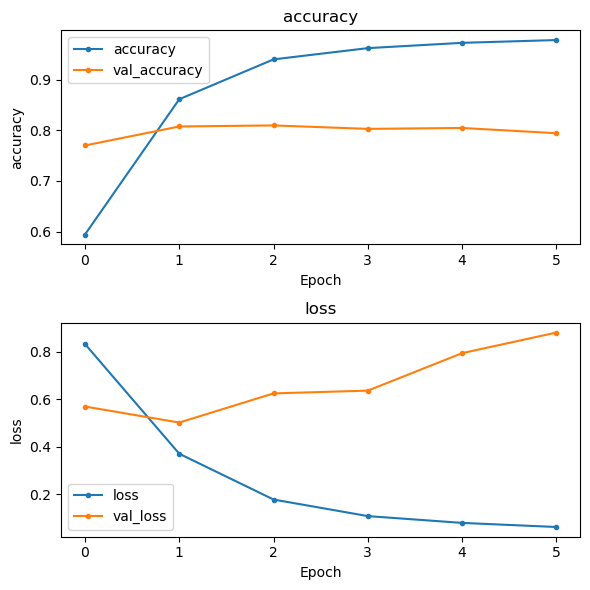


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.86      0.78       559
           1       0.86      0.77      0.81       560
           2       0.86      0.79      0.82       572

    accuracy                           0.80      1691
   macro avg       0.81      0.80      0.80      1691
weighted avg       0.81      0.80      0.80      1691



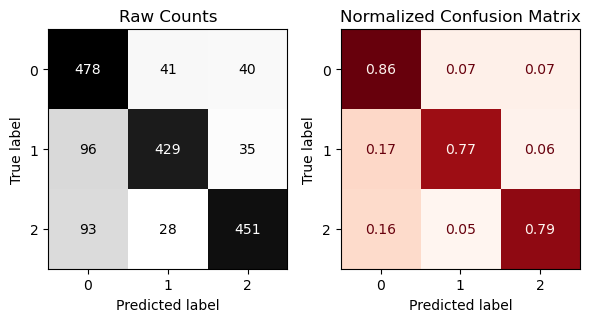


- Evaluating Test Data:
85/85 [==============================] - 4s 41ms/step - loss: 0.8418 - accuracy: 0.8031
{'loss': 0.841792643070221, 'accuracy': 0.8030750751495361}


In [20]:
results3 = mf.evaluate_classification_network(
    model3,
    X_test=test_ds, history=history3)

### Model 4

#### Improve RNN model 3 with:
-  4 GRU layers, units = 128, 64, 32
-  LSTM layer following 1st dropout layer units=128
-  Dropout layers decreasing from 0.5 to 0.1 following each GRU layer
-  Early Stoping, epochs = 18
-  GRU layer, units = 32
-  dense layer

In [26]:
def build_GRU5_LSTM(sequence_vectorizer):
    
    
    MAX_TOKENS = sequence_vectorizer.vocabulary_size()
        
    model = tf.keras.Sequential([
        sequence_vectorizer,
        layers.Embedding( input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQ_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(.3))         
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.Dropout(.1)) 
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(32, return_sequences = True)) 
  
    model.add(layers.GRU(32, return_sequences = False)) 
    # Output layer
    model.add(layers.Dense(len(classes), kernel_regularizer='l2',
                              activation='sigmoid'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [27]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [29]:
# Build model
model4= build_GRU5_LSTM_pool(sequence_vectorizer)

EPOCHS = 18
history4 = model4.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 100, 100)          2097600   
                                                                 
 gru_18 (GRU)                (None, 100, 128)          88320     
                                                                 
 dropout_15 (Dropout)        (None, 100, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 128)          131584    
                                                                 
 dropout_16 (Dropout)        (None, 100, 128)          0         
                                                      

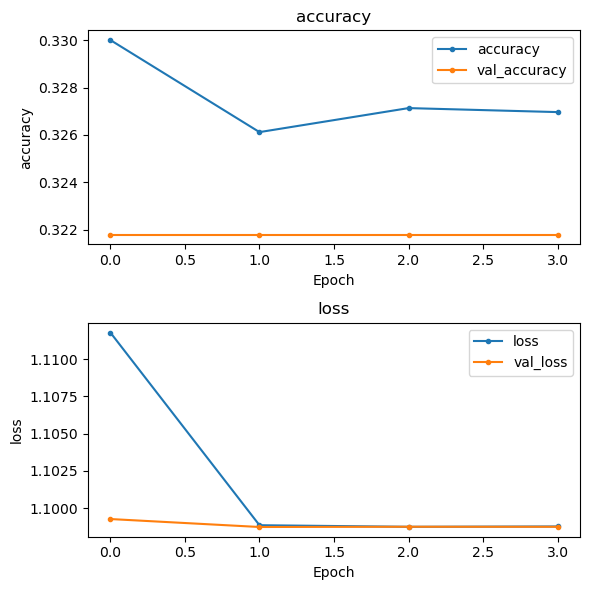


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       559
           1       0.00      0.00      0.00       560
           2       0.34      1.00      0.51       572

    accuracy                           0.34      1691
   macro avg       0.11      0.33      0.17      1691
weighted avg       0.11      0.34      0.17      1691



C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


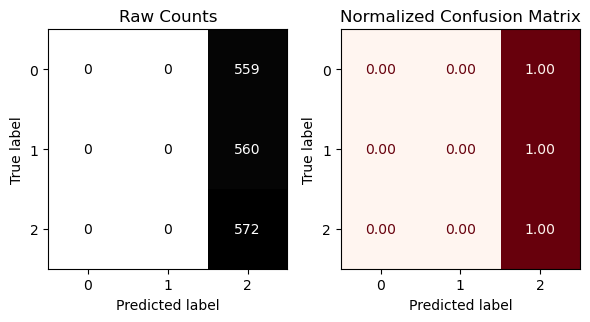


- Evaluating Test Data:
 3/85 [>.............................] - ETA: 2s - loss: 1.0983 - accuracy: 0.3667

C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\csbro\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


85/85 [==============================] - 4s 46ms/step - loss: 1.0986 - accuracy: 0.3383
{'loss': 1.0985811948776245, 'accuracy': 0.3382613956928253}


In [30]:
results4 = mf.evaluate_classification_network(
    model4,
    X_test=test_ds, history=history4)